# Plot of Sagnac Drift of Rings

## Imports

In [1]:
import os
import gc
import matplotlib.pyplot as plt
import numpy as np

from datetime import datetime, date
from pandas import DataFrame, read_pickle, date_range, concat, read_csv
from obspy import UTCDateTime, read, Trace, Stream, read_inventory


In [2]:
from functions.get_mlti_intervals import __get_mlti_intervals
from functions.mlti_intervals_to_NaN import __mlti_intervals_to_NaN
from functions.load_mlti import __load_mlti
from functions.smoothing import __smooth
from functions.interpolate_nan import __interpolate_nan
from functions.get_mlti_statistics import __get_mlti_statistics
from functions.get_lxx_intervals import __get_lxx_intervals
from functions.load_lxx import __load_lxx
from functions.find_max_min import __find_max_min
from functions.find_labels import __find_lables
from functions.read_sds import __read_sds

In [3]:
if os.uname().nodename == 'lighthouse':
    root_path = '/home/andbro/'
    data_path = '/home/andbro/kilauea-data/'
    archive_path = '/home/andbro/freenas/'
    bay_path = '/home/andbro/bay200/'
elif os.uname().nodename == 'kilauea':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'
    bay_path = '/bay200/'
elif os.uname().nodename == 'teide':
    root_path = '/home/sysopromy/'
    data_path = '/freenas-ffb-01/'
    archive_path = '/freenas-ffb-01/'
    bay_path = '/bay200/'
    lamont_path = '/lamont/'
elif os.uname().nodename in ['lin-ffb-01', 'ambrym', 'hochfelln']:
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'
    bay_path = '/bay200/'

## Configurations

In [4]:
config = {}

# specify length of time interval to show
config['time_interval'] = 21 # days

# define time interval
config['tend'] = UTCDateTime().now()
config['tbeg'] = config['tend'] - config['time_interval'] * 86400

# set time of starttime to 00:00:00
config['tbeg'] = config['tbeg'].replace(hour=0, minute=0, second=0)

Zlower, Zupper = 553.20, 553.55
Ulower, Uupper = 302.45, 302.60
Vlower, Vupper = 447.65, 447.90
Wlower, Wupper = 447.65, 447.90

# specify path to data
config['path_to_sds'] = archive_path+"romy_archive/"

# path to Sagnac beat data
config['path_to_sds'] = archive_path+f"temp_archive/"

# path to figure output
config['path_to_figs'] = archive_path+f"romy_html_monitor/figures/"

# set colors
config['colors'] = {"Z": "tab:orange", "U":"deeppink", "V":"tab:blue", "W":"darkblue"}


### Load beat data

In [5]:
try:
    beatZ = __read_sds(config['path_to_sds'], "BW.ROMY.XX.LJZ", config['tbeg'], config['tend'])
except:
    beatZ = Stream()
try:
    beatU = __read_sds(config['path_to_sds'], "BW.ROMY.XX.LJU", config['tbeg'], config['tend'])
except:
    beatU = Stream()
try:
    beatV = __read_sds(config['path_to_sds'], "BW.ROMY.XX.LJV", config['tbeg'], config['tend'])
except:
    beatV = Stream()
try:
    beatW = __read_sds(config['path_to_sds'], "BW.ROMY.XX.LJW", config['tbeg'], config['tend'])
except:
    beatW = Stream()

### Load Maintenance LXX log

In [6]:
try:
    # load log file
    lxx = __load_lxx(config['tbeg'], config['tend'], archive_path)

    # get intervals of maintenance work as utc times
    lxx_t1, lxx_t2 = __get_lxx_intervals(lxx.datetime)

except Exception as e:
    print(e)
    print(f" -> failed to load maintenance log")


### Remove MLTI times

In [7]:
try:
    # load mlti log
    mltiU = __load_mlti(config['tbeg'], config['tend'], "U", archive_path)

    # extract time intervals
    mltiU_t1, mltiU_t2 = __get_mlti_intervals(mltiU.time_utc)

    # set MLTI intervals to NaN
    # beatU = __mlti_intervals_to_NaN(beatU, "fj", "times_utc", mltiU_t1, mltiU_t2, t_offset_sec=180)

    # interpolate NaN values
    # beatU['fj_inter'] = __interpolate_nan(np.array(beatU.fj_nan))

except:
    print(f" -> failed to load mlti log for RU")

In [8]:
try:
    # load mlti log
    mltiZ = __load_mlti(config['tbeg'], config['tend'], "Z", archive_path)

    # extract time intervals
    mltiZ_t1, mltiZ_t2 = __get_mlti_intervals(mltiZ.time_utc)

    # set MLTI intervals to NaN
    # beatZ = __mlti_intervals_to_NaN(beatZ, "fj", "times_utc", mltiZ_t1, mltiZ_t2, t_offset_sec=180)

    # interpolate NaN values
    # beatZ['fj_inter'] = __interpolate_nan(np.array(beatZ.fj_nan))

except:
    print(f" -> failed to load mlti log for RZ")

In [9]:
try:
    # load mlti log
    mltiV = __load_mlti(config['tbeg'], config['tend'], "V", archive_path)

    # extract time intervals
    mltiV_t1, mltiV_t2 = __get_mlti_intervals(mltiV.time_utc)

    # set MLTI intervals to NaN
    # beatV = __mlti_intervals_to_NaN(beatV, "fj", "times_utc", mltiV_t1, mltiV_t2, t_offset_sec=180)

    # interpolate NaN values
    # beatV['fj_inter'] = __interpolate_nan(np.array(beatV.fj_nan))

except Exception as e:
    print(f" -> failed to load mlti log for RV")
    print(e)

### Get MLTI statistics

In [10]:

try:
    mlti_statsU = __get_mlti_statistics(mltiU, config['tbeg'], config['tend'],
                                        intervals=True, plot=False, ylog=False
                                       )

    mlti_statsU["mlti_series_avg"] = __smooth(mlti_statsU["mlti_series"]*30, 86400, win="boxcar")*100

except Exception as e:
    print(e)
    print(f" -> failed to get MLTI statistics for RU")

try:
    mlti_statsV = __get_mlti_statistics(mltiV, config['tbeg'], config['tend'],
                                        intervals=True, plot=False, ylog=False
                                       )

    mlti_statsV["mlti_series_avg"] = __smooth(mlti_statsV["mlti_series"]*30, 86400, win="boxcar")*100

except Exception as e:
    print(e)
    print(f" -> failed to get MLTI statistics for RV")

try:
    mlti_statsZ = __get_mlti_statistics(mltiZ, config['tbeg'], config['tend'],
                                        intervals=True, plot=False, ylog=False
                                       )

    mlti_statsZ["mlti_series_avg"] = __smooth(mlti_statsZ["mlti_series"]*30, 86400, win="boxcar")*100

except Exception as e:
    print(e)
    print(f" -> failed to get MLTI statistics for RZ")



## Smoothing

## Plotting

In [17]:
def __makeplot():

    Nrow, Ncol = 5, 1

    font = 12

    ref_date = config['tbeg']

    fig, ax = plt.subplots(Nrow, Ncol, figsize=(10, 7), sharex=True)

    plt.subplots_adjust(hspace=0.1)

    time_scaling = 1

    # Z ring plot
    try:
        if len(beatZ) > 0:
            ax[0].plot(beatZ[0].times(reftime=ref_date)*time_scaling,
                       beatZ[0].data,
                       color=config['colors']["Z"], alpha=0.9, label="RZ")
        else:
            ax[0].text(0.5, 0.5, "No Data", 
                       horizontalalignment='center',
                       verticalalignment='center',
                       transform=ax[0].transAxes,
                       fontsize=14, color='gray')
    except:
        ax[0].text(0.5, 0.5, "No Data", 
                   horizontalalignment='center',
                   verticalalignment='center',
                   transform=ax[0].transAxes,
                   fontsize=14, color='gray')

    try:
        Z_min, Z_max = __find_max_min([beatZ[0].data], 99)
        ax[0].set_ylim(max(Z_min, Zlower), min(Z_max, Zupper))
    except:
        ax[0].set_ylim(Zlower, Zupper)

    ax[0].ticklabel_format(useOffset=False)
    ax[0].set_ylabel("Horizontal\nring (Hz)", fontsize=font)

    # U ring plot
    try:
        if len(beatU) > 0:
            ax[1].plot(beatU[0].times(reftime=ref_date)*time_scaling,
                       beatU[0].data,
                       color=config['colors']["U"], alpha=0.9, label="RU")
        else:
            ax[1].text(0.5, 0.5, "No Data", 
                       horizontalalignment='center',
                       verticalalignment='center',
                       transform=ax[1].transAxes,
                       fontsize=14, color='gray')
    except:
        ax[1].text(0.5, 0.5, "No Data", 
                   horizontalalignment='center',
                   verticalalignment='center',
                   transform=ax[1].transAxes,
                   fontsize=14, color='gray')

    try:
        U_min, U_max = __find_max_min([beatU[0].data], 99)
        ax[1].set_ylim(max(U_min, Ulower), min(U_max, Uupper))
    except:
        ax[1].set_ylim(Ulower, Uupper)

    ax[1].ticklabel_format(useOffset=False)
    ax[1].set_ylabel("Northern\nring (Hz)", fontsize=font)

    # V ring plot
    try:
        if len(beatV) > 0:
            ax[2].plot(beatV[0].times(reftime=ref_date)*time_scaling,
                       beatV[0].data,
                       color=config['colors']["V"], alpha=0.9, label="RV")
        else:
            ax[2].text(0.5, 0.5, "No Data", 
                       horizontalalignment='center',
                       verticalalignment='center',
                       transform=ax[2].transAxes,
                       fontsize=14, color='gray')
    except Exception as e:
        ax[2].text(0.5, 0.5, "No Data", 
                   horizontalalignment='center',
                   verticalalignment='center',
                   transform=ax[2].transAxes,
                   fontsize=14, color='gray')

    try:
        V_min, V_max = __find_max_min([beatV[0].data], 99)
        ax[2].set_ylim(max(V_min, Vlower), min(V_max, Vupper))
    except:
        ax[2].set_ylim(Vlower, Vupper)

    ax[2].ticklabel_format(useOffset=False)
    ax[2].set_ylabel("Western\nring (Hz)", fontsize=font)

    # W ring plot
    try:
        if len(beatW) > 0:
            ax[3].plot(beatW[0].times(reftime=ref_date)*time_scaling,
                       beatW[0].data,
                       color=config['colors']["W"], alpha=0.9, label="RW")
        else:
            ax[3].text(0.5, 0.5, "No Data", 
                       horizontalalignment='center',
                       verticalalignment='center',
                       transform=ax[3].transAxes,
                       fontsize=14, color='gray')
    except Exception as e:
        ax[3].text(0.5, 0.5, "No Data", 
                   horizontalalignment='center',
                   verticalalignment='center',
                   transform=ax[3].transAxes,
                   fontsize=14, color='gray')

    try:
        W_min, W_max = __find_max_min([beatW[0].data], 99)
        ax[3].set_ylim(max(W_min, Wlower), min(W_max, Wupper))
    except:
        ax[3].set_ylim(Wlower, Wupper)

    ax[3].ticklabel_format(useOffset=False)
    ax[3].set_ylabel("Eastern\nring (Hz)", fontsize=font)


    try:
        n_rz = int(mlti_statsZ['cumsum'][-1])
        ax[4].plot(mlti_statsZ['tsec']*time_scaling, mlti_statsZ['mlti_series_avg'],
                   color=config['colors']["Z"], label=f"RZ (N={n_rz})")
        ax[4].fill_between(mlti_statsZ['tsec']*time_scaling, 0, mlti_statsZ['mlti_series_avg'],
                           color=config['colors']["Z"], alpha=0.3
                          )
    except:
        pass
    try:
        n_ru = int(mlti_statsU['cumsum'][-1])
        ax[4].plot(mlti_statsU['tsec']*time_scaling, mlti_statsU['mlti_series_avg'],
                   color=config['colors']["U"], label=f"RU (N={n_ru})")
        ax[4].fill_between(mlti_statsU['tsec']*time_scaling, 0, mlti_statsU['mlti_series_avg'],
                           color=config['colors']["U"], alpha=0.3
                          )
    except:
        pass
    try:
        n_rv = int(mlti_statsV['cumsum'][-1])
        ax[4].plot(mlti_statsV['tsec']*time_scaling, mlti_statsV['mlti_series_avg'],
                   color=config['colors']["V"], label=f"RV (N={n_rv})"
                  )
        ax[4].fill_between(mlti_statsV['tsec']*time_scaling, 0, mlti_statsV['mlti_series_avg'],
                           color=config['colors']["V"], alpha=0.3
                          )
    except:
        pass
    try:
        n_rw = int(mlti_statsW['cumsum'][-1])
        ax[4].plot(mlti_statsW['tsec']*time_scaling, mlti_statsW['mlti_series_avg'],
                   color=config['colors']["W"], label=f"RW (N={n_rw})"
                  )
        ax[4].fill_between(mlti_statsW['tsec']*time_scaling, 0, mlti_statsW['mlti_series_avg'],
                           color=config['colors']["W"], alpha=0.3
                          )
    except:
        pass

    for _n in range(Nrow):
        ax[_n].grid(ls=":", zorder=0)
        ax[_n].set_xlim(0, (config['tend'] - config['tbeg'])*time_scaling)
        _, _ , _ymin, _ymax = ax[_n].axis()

        # add maintenance times
        for lx1, lx2 in zip(lxx_t1, lxx_t2):
            lx1_sec = lx1-UTCDateTime(ref_date)
            lx2_sec = lx2-UTCDateTime(ref_date)
            ax[_n].fill_betweenx([_ymin, _ymax], lx1_sec, lx2_sec, color="yellow", alpha=0.3)
        
        # Add MLTI times for each ring
        try:
            # Z ring MLTI times
            if _n == 0:  # Z ring plot
                for t1, t2 in zip(mltiZ_t1, mltiZ_t2):
                    t1_sec = t1-UTCDateTime(ref_date)
                    t2_sec = t2-UTCDateTime(ref_date)
                    ax[_n].fill_betweenx([_ymin, _ymax], t1_sec, t2_sec, 
                                         color="red", alpha=0.2)
            # U ring MLTI times
            elif _n == 1:  # U ring plot
                for t1, t2 in zip(mltiU_t1, mltiU_t2):
                    t1_sec = t1-UTCDateTime(ref_date)
                    t2_sec = t2-UTCDateTime(ref_date)
                    ax[_n].fill_betweenx([_ymin, _ymax], t1_sec, t2_sec, 
                                         color="red", alpha=0.2)
            # V ring MLTI times
            elif _n == 2:  # V ring plot
                for t1, t2 in zip(mltiV_t1, mltiV_t2):
                    t1_sec = t1-UTCDateTime(ref_date)
                    t2_sec = t2-UTCDateTime(ref_date)
                    ax[_n].fill_betweenx([_ymin, _ymax], t1_sec, t2_sec, 
                                         color="red", alpha=0.2)
            # W ring MLTI times - if available
            elif _n == 3 and 'mltiW_t1' in globals() and 'mltiW_t2' in globals():
                for t1, t2 in zip(mltiW_t1, mltiW_t2):
                    t1_sec = t1-UTCDateTime(ref_date)
                    t2_sec = t2-UTCDateTime(ref_date)
                    ax[_n].fill_betweenx([_ymin, _ymax], t1_sec, t2_sec, 
                                         color="red", alpha=0.2)
        except Exception as e:
            pass  # Silently continue if any MLTI data is missing


    ax[4].legend(loc=1, ncol=3)
    ax[4].set_ylim(bottom=0)
    ax[4].set_ylabel("MLTI\nDensity (%)", fontsize=font)

    for _n in range(Nrow):
        ax[_n].grid(ls=":", zorder=0)
        ax[_n].set_xlim(0, (config['tend'] - config['tbeg'])*time_scaling)
        _, _ , _ymin, _ymax = ax[_n].axis()

        # add maintenance times
        for lx1, lx2 in zip(lxx_t1, lxx_t2):
            lx1_sec = lx1-UTCDateTime(ref_date)
            lx2_sec = lx2-UTCDateTime(ref_date)
            ax[_n].fill_betweenx([_ymin, _ymax], lx1_sec, lx2_sec, color="yellow", alpha=0.3)

    for i in range(5):
        ax[i].minorticks_on()
        ax[i].grid(which="both", lw=0.4, color="grey", zorder=0, ls=":")
    
    # Generate date labels for x-axis
    days_to_show = config['time_interval']
    day_seconds = 86400  # seconds in a day
    hour_seconds = 3600  # seconds in an hour
    
    # Determine appropriate tick spacing based on the time interval
    if days_to_show <= 7:  # For 1 week or less, show every day
        tick_spacing = 1
    elif days_to_show <= 14:  # For 2 weeks, show every 2 days
        tick_spacing = 2
    elif days_to_show <= 31:  # For a month, show every 3-4 days
        tick_spacing = 3
    else:  # For longer periods, show weekly ticks
        tick_spacing = 7
    
    # Create tick positions at midnight for selected days (major ticks)
    tick_positions = []
    tick_labels = []
    
    for day in range(0, days_to_show + 1, tick_spacing):
        # Calculate seconds from reference date
        tick_pos = day * day_seconds
        tick_positions.append(tick_pos)
        
        # Create date string
        date_obj = ref_date + day * day_seconds
        date_str = date_obj.strftime('%Y-%m-%d\n%H:%M:%S')
        tick_labels.append(date_str)
    
    ax[Nrow-1].set_xticks(tick_positions)
    ax[Nrow-1].set_xticklabels(tick_labels, rotation=0, ha='center')
    
    # Add minor ticks for days not shown in major ticks
    minor_tick_positions = []
    for day in range(days_to_show + 1):
        if day % tick_spacing != 0:  # If this day doesn't have a major tick
            minor_tick_pos = day * day_seconds
            minor_tick_positions.append(minor_tick_pos)
    
    ax[Nrow-1].set_xticks(minor_tick_positions, minor=True)
    
    # plt.show();
    return fig

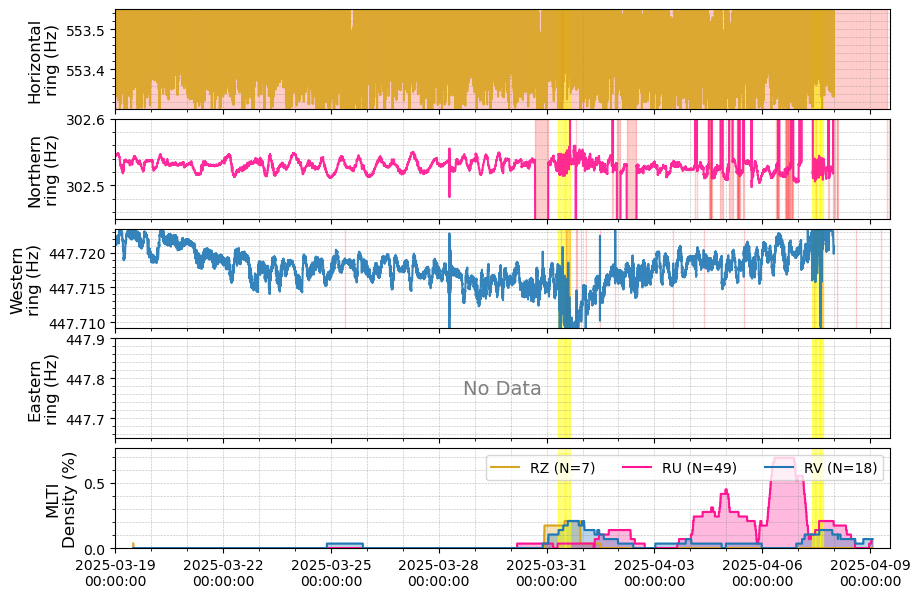

In [18]:
fig = __makeplot();

fig.savefig(config['path_to_figs']+f"html_beatdrift.png", format="png", dpi=150, bbox_inches='tight')

del fig